**Pouya Sadeghi**

fall-1401(2022)

# AI course, project #3

Naive Bayes(Classifier)

# 00. Introduction and Initialization

In this assignment, we're going to design a naive bayes classifier to classify [AsrIran](https://www.asriran.com/)'s dataset using Naive bayes Classifier.

For this purpose, we need to specify features and calculate related probabilities for the classifier.

In [1]:
import hazm

import parsivar as wp
import re

from bidi.algorithm import get_display
from arabic_reshaper import reshape

In [2]:
import json
import os

from math import log

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud_fa import WordCloudFa as WordCloud
from tqdm import tqdm

In [4]:
TEST_DATA_PATH = 'datasets/test.csv'
TRAIN_DATA_PATH = 'datasets/train.csv'

In [5]:
show_persian = lambda x: get_display(reshape(x))

## Load and Examine DataFrame

In [6]:
train_dataset = pd.read_csv(TRAIN_DATA_PATH, encoding='utf-8')

In [7]:
labels = list(train_dataset['label'].unique())
labels

['فناوری', 'ورزشی', 'حوادث', 'سلامت', 'سیاسی', 'فرهنگی/هنری']

<AxesSubplot:title={'center':'Number of samples per label'}>

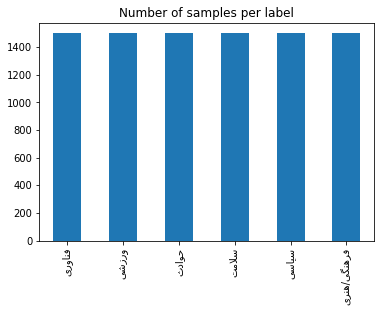

In [8]:
labels_freq = train_dataset['label'].value_counts()
labels_freq.index = labels_freq.index.map(show_persian)
labels_freq.plot(
    kind='bar', 
    title='Number of samples per label',
    )

# 01. Phase 1: Preprocessing Data

In this step, we want to make our data cleaner(normalize); we could use following methods:
- *stemming*: used to lowers inflection in words to their root forms.
- *lemmatizing*: uses the context in which the word is being used. it is the process of grouping 
together the different inflected forms of a word so they can be analyzed as a single item
- detect *stop words*: stop words are a set of commonly used words in a language.

Let's try them:

In [9]:
def test_cleaning_approach(approach: callable):
    test_words = ['دیدم', 'دیدند', 'دیده بودند', 'داشتند میدیدند', 
              'خواهند دید', 'نمی بینند', 'می بینی', 'دارم میبینم','مغازه ها','کتاب ها','پدران','بینوایان','خوشگوار']
    for w in test_words:
        print(f"{w} -> {approach(w)}")

## Stemming-parsivar

In [10]:
test_cleaning_approach(wp.FindStems().convert_to_stem)

دیدم -> دید&بین
دیدند -> دید&بین
دیده بودند -> دید&بین
داشتند میدیدند -> دید&بین
خواهند دید -> دید&بین
نمی بینند -> دید&بین
می بینی -> دید&بین
دارم میبینم -> دید&بین
مغازه ها -> مغازه
کتاب ها -> کتاب
پدران -> پدر
بینوایان -> بینوا
خوشگوار -> خوشگوار


## Stemming-hazm

In [11]:
test_cleaning_approach(hazm.Stemmer().stem)

دیدم -> دید
دیدند -> دیدند
دیده بودند -> دیده بودند
داشتند میدیدند -> داشتند میدیدند
خواهند دید -> خواهند دید
نمی بینند -> نمی بینند
می بینی -> می بین
دارم میبینم -> دارم میبین
مغازه ها -> مغازه 
کتاب ها -> کتاب 
پدران -> پدر
بینوایان -> بینوا
خوشگوار -> خوشگوار


## Lemmatizing-hazm

In [12]:
test_cleaning_approach(hazm.Lemmatizer().lemmatize)

دیدم -> دید#بین
دیدند -> دید#بین
دیده بودند -> دیده بودند
داشتند میدیدند -> داشتند میدیدند
خواهند دید -> خواهند دید
نمی بینند -> نمی بینند
می بینی -> می بینی
دارم میبینم -> دارم میبینم
مغازه ها -> مغازه ها
کتاب ها -> کتاب ها
پدران -> پدر
بینوایان -> بینوا
خوشگوار -> خوشگوار


As we can see, `Stemming-parsivar` better performs than hazm approaches;
so, we continue with parsivar.

## Stop-Words

We could deal with stop words using following approach:
- using pre-trained models
- collect some common stop words and generate our model

We collected stop words from different source and turned them to our normalized form.

In order to make my vocabulary less crowded, we consider the root(stem) form of words and verbs 
and convert the input data to the same form.

In [13]:
class StopWordDetection:
    def __init__(self, repo='stop-words.txt', n_gram=None) -> None:
        self.n_gram=n_gram
        with open(repo, 'r', encoding='utf-8') as f:
            self.stop_words = set(re.sub('[۰-۹]|[0-9]', '', f.read()).splitlines())
            print(f"Stop-Word-Detection model loaded with {len(self.stop_words)} words")
        if n_gram:
            print("- N-gram functionality enabled")
        else:
            print("- N-gram functionality disabled")
    
    def is_stop_word(self, word: str) -> bool:
        if self.n_gram:
            return any(w in self.stop_words for w in word.split(','))
        return word in self.stop_words
    
    def filter_words(self, _words: list[str]) -> list[str]:
        return [w for w in _words if not self.is_stop_word(w)]

### Test our model

In [14]:
model = StopWordDetection()
words = ['سلام', 'من', 'به', 'دنیا', 'خوش', 'آمد','با توجه به','ضمن','همراه','عین','مثلا','چگونه','امروزه']
for _w in words:
    print(f"{_w} -> if stop word: {model.is_stop_word(_w)}")
    
del words, _w, model

Stop-Word-Detection model loaded with 2374 words
- N-gram functionality disabled
سلام -> if stop word: True
من -> if stop word: True
به -> if stop word: True
دنیا -> if stop word: False
خوش -> if stop word: True
آمد -> if stop word: True
با توجه به -> if stop word: True
ضمن -> if stop word: True
همراه -> if stop word: True
عین -> if stop word: True
مثلا -> if stop word: True
چگونه -> if stop word: True
امروزه -> if stop word: True


## Normalize Data

Now, we will normalize our data using stemming-parsivar approach and detecting stop-words.

We define our approach as a class and generate it's instance for further use.

Our normalization's steps:
- delete unnecessary characters
- using words root(stem)
- delete stop-words

### define our normalizer

In [15]:
class Normalizer:
    def __init__(self, n_gram=None):
        self.n_gram = n_gram
        norm = hazm.Normalizer()
        self.basic_normalizer = norm.normalize
        token = wp.Tokenizer()
        self.word_tokenizer = token.tokenize_words
        self.stop_word_detector = StopWordDetection(n_gram=n_gram).filter_words
        stem = wp.FindStems()
        self.stemmer = lambda w: stem.convert_to_stem(w).split('&')[0]
    
    def enable_method(self, *methods):
        for method in methods:
            if 'stem' in method:
                self.stemmer = lambda w: wp.FindStems().convert_to_stem(w).split('&')[0]
            elif 'stop-word' in method or 'stop word' in method:
                self.stop_word_detector = StopWordDetection().filter_words
            else:
                print(f"Unknown method {method}")
    
    def disable_method(self, *methods):
        for method in methods:
            if 'stem' in method:
                self.stemmer = None
            elif 'stop-word' in method or 'stop word' in method:
                self.stop_word_detector = None
            else:
                print(f"Unknown method {method}")
        
    def __prepare_statement(self, statement: str):
        statement = self.basic_normalizer(statement)
        number={'0':'۰','1':'۱','2':'۲','3':'۳',
                '4':'۴','5':'۵','6':'۶','7':'۷',
                '8':'۸','9':'۹'}
        
        punctuations = [
            '(',')','\'','\"',';','.',',',':',';','[',']','{','}','،','؛','»','«',
            '؟','!','?','٬','\n','\r','_',',', '.', '-', '...',
            ]
        for p in punctuations:
            statement = statement.replace(p, '')
        for i,j in number.items():
            statement = statement.replace(j,i)
        statement = ' '.join(re.findall(r'(?:[^\W\d_]+\d|\d+[^\W\d_])[^\W_]*|[^\W\d_]+',statement))
        statement = statement.replace('\u200c', '').replace('\u200e', '')
        return statement

    def __prepare_words(self, _words: list[str]) -> list[str]:
        if self.stemmer is None:
           stemmed = _words
        else:
            stemmed = [
                self.stemmer(word).replace('\u200c', '').replace('\u200f','').replace('\u2066','') for word in _words
                ]
        if self.n_gram is not None:
            prepared = []
            for n in self.n_gram:
                prepared.extend(
                    [','.join(stemmed[i:i+n]) for i in range(len(stemmed)-n+1)]
                    )
        else : 
            prepared = stemmed
            
        return prepared
    
    def __filter_stop_words(self, _words: list[str]) -> list[str]:
        if self.stop_word_detector is None:
            return _words
        filtered = self.stop_word_detector(_words)
        return filtered
    
    def normalize(self, statement: str) -> list[str]:
        prepared = self.__prepare_statement(statement)
        tokens = self.word_tokenizer(prepared)
        normalized = self.__filter_stop_words(self.__prepare_words(tokens))
        return normalized
    
    def str_normalize(self, statement: str) -> str:
        return ' * '.join(self.normalize(statement))
        

## Bigrams

Using N-gram approach could increase the amount of information captured from context.

N-grams are used for a variety of things:
- auto completion of sentences (such as the one we see in Gmail these days)
- auto spell check (yes, we can do that as well)
- check for grammar in a given sentence

In some cases, using uni_grams might increase inaccuracy of the model and confuse it, such as:
1. en:
    - The pencil has a sharp point
    - It is not polite to point at people
2. fa:
    - میل به غذا ندارم چون سیر هستم
    - در غذا سیر وجود دارد  

In the first example, with uni-gram, we won't consider any differences between the word `point`, both as we can see, it used in different meanings;
by using bi-gram, we can understand the difference:
- sharp point
- point at

Also, in auto-completion models, n-grams play an important role to predict the rest of the sentence and make better predictions as we write each word(they use n-grams).

### how to use it in our model?

We have embedded n-gram's in our `Normalizer`. you just need to pass $[N_1, N_2, ...]$ when instantiating an instance of it.

### instantiate and test normalizer

In [16]:
normalizer = Normalizer()

normalizer.normalize(train_dataset['content'][0])

Stop-Word-Detection model loaded with 2374 words
- N-gram functionality disabled


['گزارش',
 'منتشر',
 'کاربر',
 'تلگرام',
 'مناطقی',
 'جهان',
 'اروپا',
 'خاورمیانه',
 'گزارش',
 'نقل',
 'تلگرام',
 'دقایقی',
 'پیام',
 'تلگرام',
 'صفحه',
 'توییتر',
 'دسترسی',
 'کاربر',
 'اپلیکیشن',
 'اروپا',
 'خاورمیانه',
 'پیام',
 'منشا',
 'اختلالات',
 'خارجی',
 'پیام',
 'ارتباطی',
 'کشور',
 'پیام',
 'متخصص',
 'تلگرام',
 'متوجه',
 'اختلال',
 'بررسی',
 'برطرف',
 'مربوطه',
 'امید',
 'اختلال',
 'رفع',
 'کاربر',
 'حساب',
 'کاربری',
 'تلگرام',
 'دسترسی']

# 02. Phase 2: Problem Process

## Generate Model

### Extract bag of words

In [17]:
def count_word_repetition(_df: pd.DataFrame, _normalizer) -> dict:
    freq = dict()
    contents = _df['content'].map(_normalizer)
    for content in contents:
        for word in content:
            if word in freq:
                freq[word] += 1
            else:
                freq[word] = 1
    return freq

def generate_word_bag(_df, _labels, _normalizer):
    bag_of_words = dict()
    for label in tqdm(_labels, desc="Extracting bag-of-words for labels"):
        bag_of_words[label] = count_word_repetition(_df[_df['label'] == label], _normalizer)
    return bag_of_words
    

In [18]:
word_bag = generate_word_bag(train_dataset, labels, normalizer.normalize)

Extracting bag-of-words for labels: 100%|██████████| 6/6 [00:20<00:00,  3.44s/it]


In [19]:
def plot_word_cloud(_words_bag: dict, _label: str, _coordinates):
    print(f"{_label}: {len(_words_bag[_label])}")
    if len(_words_bag[_label]) == 0:
        return
    wordcloud = WordCloud(
        background_color='black',
        width=800,
        height=800,
        max_words=150,
        max_font_size=100,
        random_state=42
    ).generate_from_frequencies(_words_bag[_label])
    plt.subplot(_coordinates[0], _coordinates[1], _coordinates[2])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(show_persian(_label), fontsize=20, color='white')
    
def plot_word_clouds(_words_bag: dict, _labels):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('xkcd:black')
    for idx, label in enumerate(_labels, start=1):
        plot_word_cloud(_words_bag, label, (2, 3, idx))
    plt.show()


فناوری: 15502
ورزشی: 10547
حوادث: 9594
سلامت: 13806
سیاسی: 14887
فرهنگی/هنری: 19814


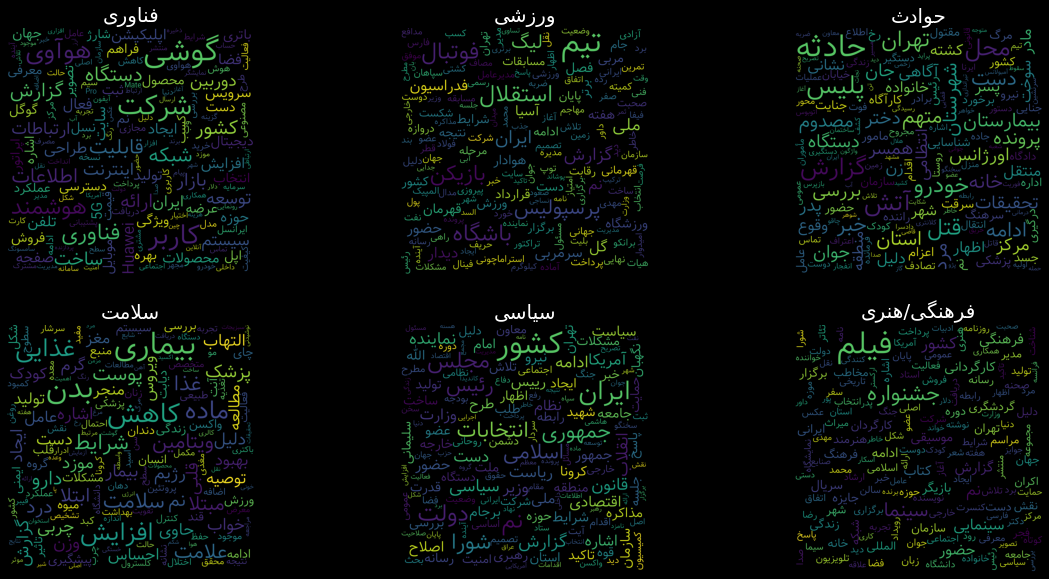

In [20]:
plot_word_clouds(word_bag, _labels=labels)

### How does model works?



The feature for the classifier is the number of words of each label used in the dataset.

Our model would be based on bayes equation: $$P(c|x) = \frac{P(x|c)P(c)}{P(x)}$$

$x$: The word detected as evidence

$c$: Label(class)

$P(c|x)$: Probability of predicting record as label c, knowing word x has appeared in the context(news title) as evidence(Posterior Probability)

$P(x|c)$: Probability of that word x appears in the contexts with label c(Likelihood); we could calculate it using our bag-of-words for each label 

$P(c)$: Probability of labeling as label c(Class Prior Probability); it is calculated as the fraction of label c to total labels; as it is common for all categories, we won't calculate it.

$P(x)$: Probability of seeing word x in the context(Predictor Prior Probability (Evidence)). We don't really need to calculate this probability; because it is common in all probabilities we need to calculate; so, we just ignore it (assume it is calculated and used)

**Attention**: we used term word, but our model would consider all words extracted from given record(by multiplying their probability).

#### Additive Smoothing

Now, imagine that we have a sentence, which has a word that ocurred in only one label(or even none of them) and this entity belongs to class *C*; now, $P(x|c) = 0$, which will result in $P(c|x) = 0$
and we won't consider this class in our options. it could gets worse if we have an unseen word(leading all probabilities to zero). the solution is to use *Additive Smoothing*.

In this approach, instead of using the tradition-old-equation $P(A)=\frac{N_A}{N}$ we use $P = \frac{Wordcount + \alpha}{Totalcount + \alpha * |V|}$, which:
- $\alpha$ is smoothing factor.
- sum of the probabilities is 1

Using A.S. we assigned a non-zero probability to each word to avoid the problem mentioned above.

# 03. Bayes based text-classification model

In [21]:
class Classifier:
    __config = {
        'smart-restriction':True,
        'save':True,
    }
    def __init__(self, load=True, **kwargs):
        if 'n_gram' in kwargs:
            ng = list(kwargs['n_gram'])
            self.preprocessor=Normalizer(n_gram=ng)
        else:
            ng = [1]
            self.preprocessor=Normalizer()
        ng = [str(n) for n in ng]
        nl = '_' + '_'.join(ng) + '.json'
        
        self.file_name = 'statistics' + nl
        self.probabilities=None
        self.restricted=set()
        self.labels=None
        self.ignorance_threshold=0.0001
        self.power_ratio=5
        if 'smoothing' in kwargs:
            self.smoothing_factor=kwargs['smoothing']
        else:
            self.smoothing_factor=0
        if load:
            if self.load():
                print(f"Model loaded successfully")
            else:
                print("Couldn't load model")
        print("Model configs")
        print(f"- smart-restriction: {self.__config['smart-restriction']}")
        print(f"- n-gram for: {', '.join(ng)}")
        print(f"- smoothing is disabled" if self.smoothing_factor==0 else f"- smoothing with alpha -> {self.smoothing_factor}")
        
    def _save_statistic(self, _words):
        if not self.__config['save']:
            return
        with open(self.file_name, 'w', encoding='utf-8') as f:
            json.dump(_words, f, ensure_ascii=False)
        
    def __offload_zero_probabilities(self):
        for label in self.labels:
            new_prob_set = {
                word:prob for word, prob in self.probabilities[label].items() if prob > 0
            }
            self.probabilities[label] = new_prob_set
        
    def __auto_restriction(self):
        if not self.__config['smart-restriction']:
            return
        for label in tqdm(self.labels, desc="Smart Restricting"):
            for word in self.probabilities[label]:
                v1 = self.probabilities[label][word]
                if v1 == 0:
                    continue
                if word in self.restricted:
                    continue
                repeats = [(v1, label)]
                for l in self.labels:
                    if l == label:
                        continue
                    if word not in self.probabilities[l]:
                        continue
                    v2 = self.probabilities[l][word]
                    if v2 != 0:
                        repeats.append((v2, l))
                if len(repeats) < 2:
                    continue
                repeats.sort(key=lambda x: x[0], reverse=True)
                if repeats[0][0] == 0:
                    continue
                ratio = repeats[0][0]/repeats[1][0]
                if ratio < self.power_ratio:
                    self.restricted.add(word)
                    continue
                for vv, ll in repeats[1:]:
                    self.probabilities[ll][word] = (self.smoothing_factor) / (self.total_words[ll][0] + self.smoothing_factor * self.total_words[ll][1])
                    
    def __label_train(self, _bag, _label):
        probabilities = dict()
        for w in _bag[_label]:
            prob = (_bag[_label][w] + self.smoothing_factor) / (self.total_words[_label][0] + self.smoothing_factor * self.total_words[_label][1]) 
            probabilities[w]=prob
        return probabilities
        
    def __train(self, _words:dict[dict[int]]):
        if self.labels is None:
            self.labels = tuple(_words.keys())
        self.probabilities = dict()
        self.total_words = dict()
        for label in tqdm(self.labels, desc="Calculating probabilities"):
            self.total_words[label] = (sum(_words[label].values()), len(_words[label]))
            self.probabilities[label] = self.__label_train(_words, label)
        self.__auto_restriction()
        # self.__offload_zero_probabilities()
        
    def _word_train(self, _words):
        self._save_statistic(_words)
        self.__train(_words)
        
    def _df_train(self, df):
        self.labels = tuple(df['label'].unique())
        bag_of_words = generate_word_bag(df, self.labels, self.preprocessor.normalize)
        self._word_train(bag_of_words)
        
    def train(self, _words=None, _df=None):
        if self.probabilities is not None:
            print("Model has already trained")
            return False
        if _words is not None:
            self._word_train(_words)
            return True
        if _df is not None:
            self._df_train(_df)
            return True
        raise Exception("You should provide data to train model")
    
    def restrict(self, *_words):
        self.restricted.union(set(_words))
            
    def load(self):
        if not os.path.exists(self.file_name):
            return False
        with open(self.file_name, 'r', encoding='utf-8') as f:
            _words = json.load(f)
        print("Training model from previous train session")
        self.__train(_words)
        return True
    
    def __score_per_label(self, tokens):
        total_words = sum(r[0] for r in self.total_words.values())
        scores = {label:log(self.total_words[label][0]/total_words) for label in self.labels}
        for idx, token in enumerate(tokens, start=0):
            if token in self.restricted:
                continue
            for label in self.labels:
                if token in self.probabilities[label]:
                    prob = self.probabilities[label][token]
                else:
                    if ',' in token:
                        v = False
                        for t in token.split(','):
                            if t in tokens[:idx]:
                                v = True
                                break
                        if v:
                            continue
                    prob =  self.smoothing_factor/\
                            (self.total_words[label][0] + self.smoothing_factor * self.total_words[label][1])
                score = log(prob) if prob !=0 else float('-inf')
                scores[label] += score
        return scores
    
    def predict(self, statement):
        """Returns as (label, probability)"""
        if self.probabilities is None:
            raise Exception("You should train your model first")
        tokens = self.preprocessor.normalize(statement)
        scores_per_label = self.__score_per_label(tokens)
        scores = [(label, scores_per_label[label]) for label in self.labels]
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[0][0]
        
    def change_config(self, conf, val):
        if conf not in self.__config:
            print("Config doesn't exist")
            return
        self.__config[conf] = val
        

## Create Models

### Uni-gram model

In [22]:
first_model = Classifier()
first_model.train(_df=train_dataset)

Stop-Word-Detection model loaded with 2374 words
- N-gram functionality disabled
Couldn't load model
Model configs
- smart-restriction: True
- n-gram for: 1
- smoothing is disabled


Smart Restricting: 100%|██████████| 6/6 [00:00<00:00, 50.85it/s]


True

### Uni-gram + Bi-gram model

In [23]:
second_model = Classifier(n_gram=[1,2])
second_model.train(_df=train_dataset)

Stop-Word-Detection model loaded with 2374 words
- N-gram functionality enabled
Couldn't load model
Model configs
- smart-restriction: True
- n-gram for: 1, 2
- smoothing is disabled


Smart Restricting: 100%|██████████| 6/6 [00:00<00:00, 11.11it/s]


True

### Uni-gram + Additive-smooth

In [24]:
third_model = Classifier(smoothing=1)
third_model.train(_df=train_dataset)

Stop-Word-Detection model loaded with 2374 words
- N-gram functionality disabled
Training model from previous train session


Smart Restricting: 100%|██████████| 6/6 [00:00<00:00, 65.21it/s]

Model loaded successfully
Model configs
- smart-restriction: True
- n-gram for: 1
- smoothing with alpha -> 1
Model has already trained


False

# 04. Check correctness

For this part, plot 10 most repeated word in each class; then we check out auto restriction functionality for our model.

In [25]:
def plot_frequent_words(_word_bag, _labels, n=10):
    fig, ax = plt.subplots(nrows=(len(labels)+2)//3, ncols=3, figsize=(27,10))
    fig.supxlabel("Words")
    fig.supylabel("Frequency")
    sp, i = 0, 0
    for l in _labels:
        frequents = dict(sorted(_word_bag[l].items(), key=lambda x: x[1], reverse = True)[:n])
        words = frequents.keys()
        repeats = frequents.values()
        ax[i][sp].bar([show_persian(w) for w in words], repeats)
        ax[i][sp].set_title(show_persian(l))
        i = i+1 if sp == 2 else i
        sp = (sp + 1) % 3
    plt.show() 

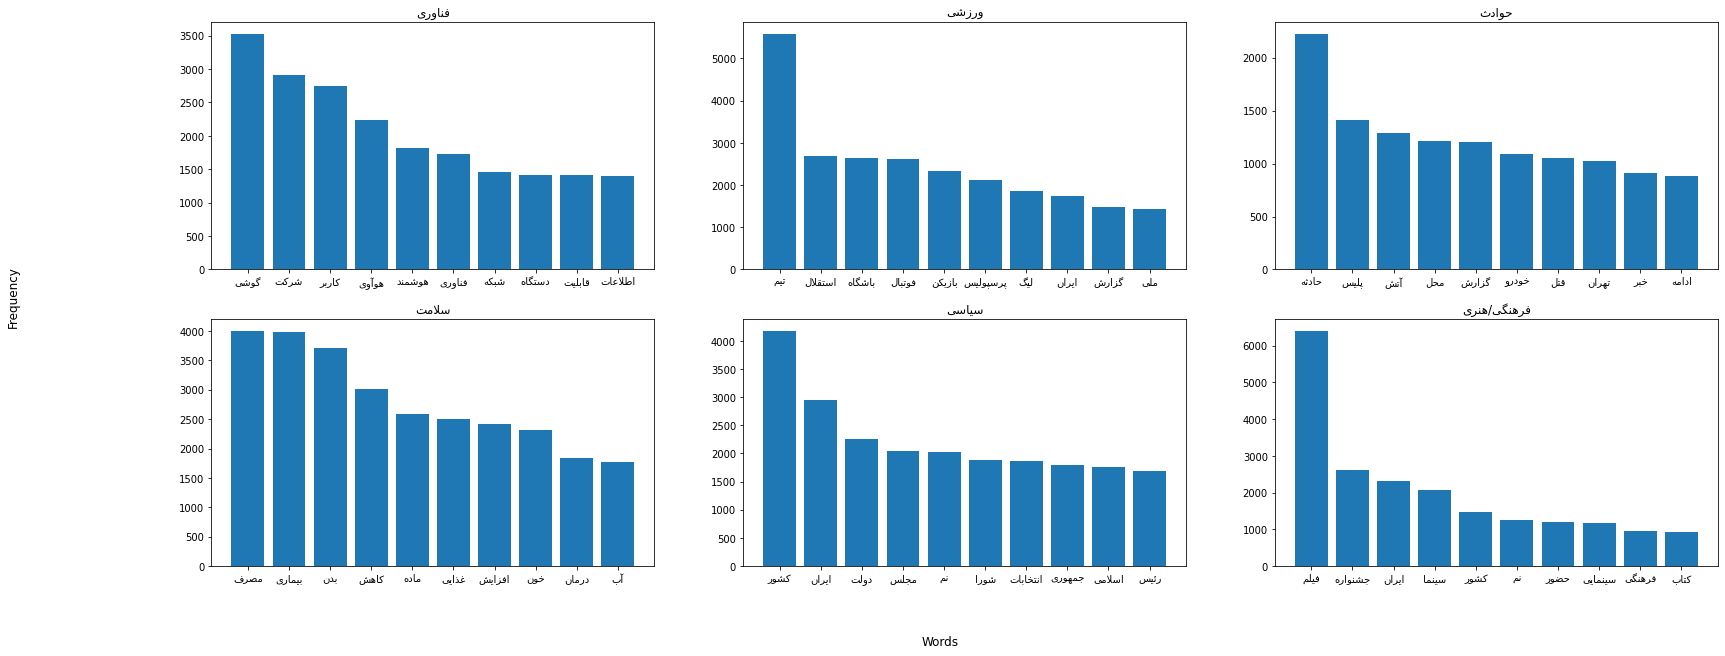

In [26]:
plot_frequent_words(word_bag, labels)

## Check out auto restriction

In [27]:
should_discard = ['کشور','ایران','گزارش', 'نم']

In [28]:
for idx, w in enumerate(should_discard, start=1):
    print(f"restricted #{idx}: {w in first_model.restricted}")

restricted #1: True
restricted #2: True
restricted #3: True
restricted #4: True


# 05. Phase 3: Evaluation

## Predict test-dataset

In [29]:
def predict_on_df(df, model: Classifier):
    predicted = []
    for entity in tqdm(df['content'], desc="Predicting"):
        predicted.append(model.predict(entity))
    return np.array(predicted)

In [30]:
def correctness_rate(predicted, actual):
    return (predicted == actual).sum()/len(predicted)

In [31]:
test_dataset = pd.read_csv(TEST_DATA_PATH, encoding='utf-8')

## test models

### uni-gram & without additive smoothing 

In [32]:
m1_predicted = predict_on_df(test_dataset, first_model)
print(f"Correctness rate of first model: {100 * correctness_rate(m1_predicted, test_dataset['label']):.1f}%")

Predicting: 100%|██████████| 1115/1115 [00:03<00:00, 368.49it/s]

Correctness rate of first model: 25.9%


### uni-gram + bi-gram & without additive smoothing 

In [33]:
m2_predicted = predict_on_df(test_dataset, second_model)
print(f"Correctness rate of second model: {100 * correctness_rate(m2_predicted, test_dataset['label']):.1f}%")

Predicting: 100%|██████████| 1115/1115 [00:04<00:00, 264.65it/s]

Correctness rate of second model: 25.2%


### uni-gram & with additive smoothing 

In [34]:
m3_predicted = predict_on_df(test_dataset, third_model)
print(f"Correctness rate of third model: {100 * correctness_rate(m3_predicted, test_dataset['label']):.1f}%")

Predicting: 100%|██████████| 1115/1115 [00:02<00:00, 419.01it/s]

Correctness rate of third model: 91.6%


As we can see, model with additive smooth has the best correctness of all

## Extract evaluation parameters

Parameters:

- Accuracy

$$Accuracy = \frac{Correct Detected}{Total}$$

- Precision

$$Precision = \frac{Correct Detected Class}{All Detected Class}$$

- Recall

$$Recall = \frac{Correct Detected Class}{Total Class}$$

- F1

$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$

In [35]:
def extract_parameters(test_df, predicted, classes):
    parameters = dict()
    parameters['Accuracy'] = (test_df['label'] == predicted).sum()/len(test_df)
    parameters['Precision'] = dict()
    parameters['Recall'] = dict()
    parameters['F1'] = dict()
    for _class in classes:
        mask = test_df['label'] == _class
        parameters['Precision'][_class] = (
                (test_df[mask]['label'] == predicted[mask]).sum()/(predicted == _class).sum()
        ) if (predicted == _class).sum() != 0 else 0
        parameters['Recall'][_class] = (
                (test_df[mask]['label'] == predicted[mask]).sum()/mask.sum()
        ) if mask.sum() != 0 else 0
        parameters['F1'][_class] = 0
        if parameters['Precision'][_class] > 0 or parameters['Recall'][_class] > 0:
            parameters['F1'][_class] = 2 * (
                (parameters['Precision'][_class] * parameters['Recall'][_class]) / (parameters['Precision'][_class] + parameters['Recall'][_class])
                )
    return parameters

In [36]:
def print_extracted_parameters(parameters, model_name):
    print(f"Model {model_name} scores:")
    print(f"- Accuracy: {parameters['Accuracy']}")
    labels = parameters['Precision'].keys()
    for l in labels:
        print(f"- Statistic for {l}:")
        print(f"  Precision: {parameters['Precision'][l]}")
        print(f"  Recall: {parameters['Recall'][l]}")
        print(f"  F1: {parameters['F1'][l]}")

In [37]:
params_1 = extract_parameters(test_dataset, m1_predicted, labels)
params_2 = extract_parameters(test_dataset, m2_predicted, labels)
params_3 = extract_parameters(test_dataset, m3_predicted, labels)

## Measure Model Performance

### multi-class metrics

- Macro-F1(regular averaging): $$\frac{\sum_{c \in labels} F_c}{Number Of Labels}$$

- Weighted-F1(consider the portion of each class in dataset): $$\frac{\sum_{c \in labels} count(SamplesOfClass_c)*F_c}{\sum_{c \in labels} count(SamplesOfClass_c)}$$

- Micro-F1(simply calculate accuracy): $$\frac{Correctly Classified Samples}{Total Samples}$$

In [38]:
def parameters_to_metrics(parameters, total_words_per_labels):
    labels = total_words_per_labels.keys()
    metrics = dict()
    metrics['Micro-F1'] = parameters['Accuracy']
    metrics['Macro-F1'] = sum(parameters['F1'].values()) / len(labels)
    weighted = 0
    div = 0
    for l in labels:
        weighted += total_words_per_labels[l][0] * parameters['F1'][l]
        div += total_words_per_labels[l][0]
    metrics['weighted-F1'] = weighted / div
    
    return metrics

In [39]:
metric1 = parameters_to_metrics(params_1, first_model.total_words)
metric2 = parameters_to_metrics(params_2, second_model.total_words)
metric3 = parameters_to_metrics(params_3, third_model.total_words)

In [40]:
def report_as_df(parameters, metrics, labels):
    df = pd.DataFrame(
        columns=np.append(labels, "All Classes"),
        index=['Precision', 'Recall', 'F1-score', 'Accuracy', 'Macro Avg',
                                  'Micro Avg', 'Weighted Avg']
        )
    for l in labels:
        df.loc['Precision', l] = 100 * parameters['Precision'][l]
        df.loc['Recall', l] = 100 * parameters['Recall'][l]
        df.loc['F1-score', l] = 100 * parameters['F1'][l]
    df.loc['Accuracy', 'All Classes'] = parameters['Accuracy'] * 100
    df.loc['Macro Avg', 'All Classes'] = metrics['Macro-F1'] * 100
    df.loc['Micro Avg', 'All Classes'] = metrics['Micro-F1'] * 100
    df.loc['Weighted Avg', 'All Classes'] = metrics['weighted-F1'] * 100
    df = df.fillna('-')
    return df

### Performance report for each model

#### +uni, -smoothing

In [41]:
report1 = report_as_df(params_1, metric1, labels)
report1

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,16.803279,100.0,96.153846,67.567568,96.296296,100.0,-
Recall,97.619048,17.894737,12.5,14.124294,13.0,8.333333,-
F1-score,28.671329,30.357143,22.123894,23.364486,22.907489,15.384615,-
Accuracy,-,-,-,-,-,-,25.919283
Macro Avg,-,-,-,-,-,-,23.801493
Micro Avg,-,-,-,-,-,-,25.919283
Weighted Avg,-,-,-,-,-,-,23.572328


#### +uni+bi, -smoothing

In [42]:
report2 = report_as_df(params_2, metric2, labels)
report2

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,16.666667,97.058824,96.153846,67.647059,96.0,100.0,-
Recall,97.619048,17.368421,12.5,12.99435,12.0,6.666667,-
F1-score,28.472222,29.464286,22.123894,21.800948,21.333333,12.5,-
Accuracy,-,-,-,-,-,-,25.201794
Macro Avg,-,-,-,-,-,-,22.61578
Micro Avg,-,-,-,-,-,-,25.201794
Weighted Avg,-,-,-,-,-,-,22.234273


#### +uni, +smoothing

In [43]:
report3 = report_as_df(params_3, metric3, labels)
report3

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,93.209877,96.373057,84.782609,85.294118,94.505495,99.305556,-
Recall,89.880952,97.894737,97.5,98.305085,86.0,79.444444,-
F1-score,91.515152,97.127937,90.697674,91.338583,90.052356,88.271605,-
Accuracy,-,-,-,-,-,-,91.569507
Macro Avg,-,-,-,-,-,-,91.500551
Micro Avg,-,-,-,-,-,-,91.569507
Weighted Avg,-,-,-,-,-,-,91.211751


### Wrong predictions

In [44]:
def get_wrong_prediction(pure_df, predicted):
    df = pure_df.copy(deep=True)
    df['predicted_labels'] = predicted
    return df

In [45]:
m1_complete = get_wrong_prediction(test_dataset, m1_predicted)
m3_complete = get_wrong_prediction(test_dataset, m3_predicted)

# Discussions

In this part, we answer each question.

**Pay Attention**: moth of questions have answered in the above part, with more details.

## 01. what is the difference between *stemming* and *lemmatizing*?

Both of them are methods used to analyze the meaning behind a word, by reducing inflectional forms and sometimes derivational related forms of a word to a common base form.

***stemming***: usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes

***lemmatizing***: usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

given from [nlp.stanford](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

So. as we can see, by using these two methods, we want to convert words(derivationally related forms) to a same form.

- by experience, we decided to use parsivar/stemming.

## 02. explain Posterior, Likelihood, class Prior, Predictor Prior Probabilities in Bayes equation and how they calculated.

$$P(c|x) = \frac{P(x|c)P(c)}{P(x)}$$

$x$: The word detected as evidence

$c$: Label(class)

$P(c|x)$: Probability of predicting record as label c, knowing word x has appeared in the context(news title) as evidence(Posterior Probability)
$->$ calculated from Bayes equation

$P(x|c)$: Probability of that word x appears in the contexts with label c(Likelihood); 
we could calculate it using our bag-of-words for each label by $\frac{Word Occurrences}{Total Word Occurrences(In Class C)}$

$P(c)$: Probability of labeling as label c(Class Prior Probability); it is calculated as the fraction of label c to total labels; as it is common for all categories, we won't calculate it.
$->$ $\frac{1}{Total Classes}$

$P(x)$: Probability of seeing word x in the context(Predictor Prior Probability (Evidence)). We don't really need to calculate this probability; because it is common in all probabilities we need to calculate; so, we just ignore it (assume it is calculated and used and then we scaled out probabilities)
$->$ $\frac{Word Occurrences}{Total Word Occurrence}$

## 03. with example, show how bi-grams could help us.

In some cases, using uni_grams might increase inaccuracy of the model and confuse it, such as:
- The pencil has a sharp point
- It is not polite to point at people

In this example, with uni-gram, we won't consider any differences between the word `point` in each sentence. as we can see, they used in different meanings;
by using bi-gram, we can understand the difference:
- sharp point
- point at

## 04. what would happen, if you have a word that hasn't appeared in all classes of train data(appeared in some of them or none of them) regarding to naive bayes?

It can lead to pure accuracy. model would consider this entity for one class ore even in none of them
(because once the probability gets zero, the model won't consider the rest of the word in that entity for other classes that hasn't that word).

Imagine that we have a sentence, which has a word that ocurred in only one label(or even none of them) and this entity belongs to class *C*; now, $P(x|c) = 0$, which will result in $P(c|x) = 0$
and we won't consider this class in our options. it could gets worse if we have an unseen word(leading all probabilities to zero). the solution is to use *Additive Smoothing*.
in this way, we give other classes a chance to participate in predicting in the above scenario.

Situations get worse for n-gram mode because when we haven't seen a word, we also haven't seen that in any context, which leads to more $P(x|c) = 0$. we tried to reduce its effect with some conditions. You could also make it better using high smoothing factor.

## 05. how Additive Smoothing could solve the problem of #04?

Using $P = \frac{Wordcount + \alpha}{Totalcount + \alpha * |V|}$ instead of $P(A)=\frac{N_A}{N}$:

Using A.S. we assigned a non-zero probability to each word to avoid the problem mentioned above.
in this way, we give other classes, a chance to participate in prediction-process in the above scenario.

## 06. Plot word-frequencies for each label and restrict common words with high frequencies in more than one class.

You can also visit this part of the notebook: [check correctness](#04-check-correctness)

for some words that have high frequencies in more then one class, we designed a functionality an our model to ignore this words, also an auto feature for examining all features(and decide what to do with them).

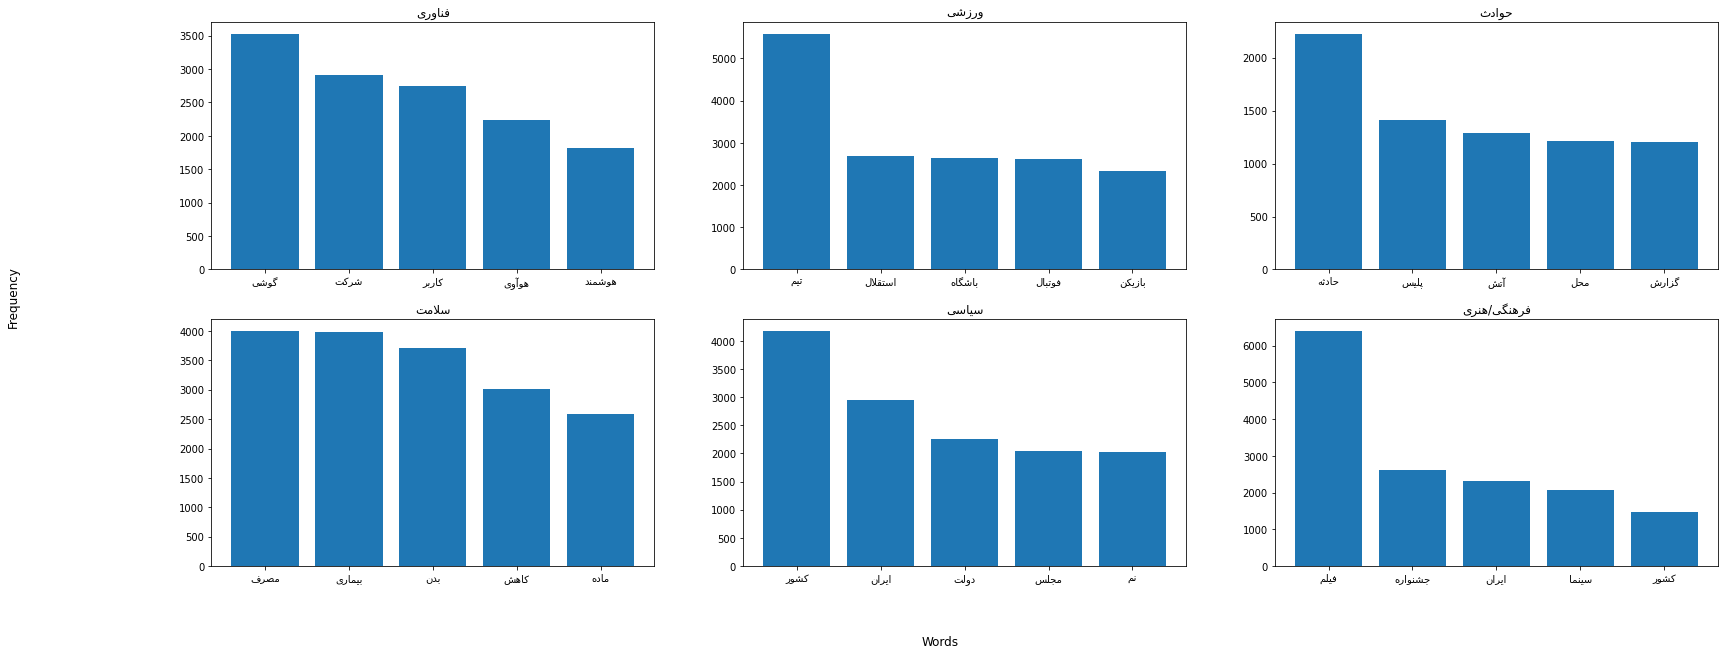

In [46]:
plot_frequent_words(word_bag, labels, n=5)

## 07. why we can't use only *Recall* or only *Precision*?

Precision answering the question: what portion of `predicted positives` is truly positive.
it defined as : $\frac{TruePositive}{TruePositive+FalsePositive}$.

Recall answering the question: what portion of `actual positives` is correctly classified.
it defined as : $\frac{TruePositive}{TruePositive+FalseNegative}$.

As we can see, each of them are speaking about different aspects of the model;
*Precision* won't take care of `false negative` while *Recall* ignoring `false positive`.

Imagine a model that could label 1 out of 100 sample with class C as c:  
$precision=\frac{1}{1+0} = 1$;
so, its gets score of $100\%$(which can't describe this model performance correctly).

In the other hand, imagine a model that labels are entities(of all classes) as c(we have N entitya and M with label c):  
$recall=\frac{M}{M+0} = 1$;
so, its gets score of $100\%$(which can't describe this model performance correctly).

It is clear that they can cover their weakness, so we need to use both of them.

## 08. how does F1 calculate average value between Recall and Precision and why?

It uses *harmonic mean* instead of *arithmetic mean*:  $F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$

You could see the main difference in this example.
consider we have two models with following scores:
1. $Precision=Recall=80\%$
2. $Precision=60\%, Recall=100\%$

now consider F1-score and regular-average for the above example:
- arithmetic mean: is $80\%$ for both of them.
- harmonic mean:
    - first model: $80\%$
    - second model: $75\%$

Sound like F1-score gives larger weight to lower numbers(bolding weaknesses)

Using F1-score, will consider both false positive and false negative, also, give higher score
to the model with better overall performance. this is why F1-scores are widely used as a metric.
 

## 09. what about multi-class metrics? also, explain Macro&Micro&Weighted averages.

As we have multi-classes in here, we want convert per-class F1-scores into a single number, as the classifier's overall F1-score. there are a few ways of doing that:

- Macro-F1(regular averaging): it computes as simple arithmetic mean of our per-class F1-scores: $\frac{\sum_{c \in labels} F_c}{Number Of Labels}$

- Weighted-F1(consider the portion of each class in dataset): weight the F1-score of each class by the number of samples from that class: $\frac{\sum_{c \in labels} count(SamplesOfClass_c)*F_c}{\sum_{c \in labels} count(SamplesOfClass_c)}$

- Micro-F1(simply calculate accuracy): finally we can simply equation to Accuracy-equation: $\frac{Correctly Classified Samples}{Total Samples}$

## 10. report model performance with/without additive smoothing.

We just need report1 and report3

#### for model without additive smoothing



In [47]:
report1

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,16.803279,100.0,96.153846,67.567568,96.296296,100.0,-
Recall,97.619048,17.894737,12.5,14.124294,13.0,8.333333,-
F1-score,28.671329,30.357143,22.123894,23.364486,22.907489,15.384615,-
Accuracy,-,-,-,-,-,-,25.919283
Macro Avg,-,-,-,-,-,-,23.801493
Micro Avg,-,-,-,-,-,-,25.919283
Weighted Avg,-,-,-,-,-,-,23.572328


#### for model with additive smoothing



In [48]:
report3

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,93.209877,96.373057,84.782609,85.294118,94.505495,99.305556,-
Recall,89.880952,97.894737,97.5,98.305085,86.0,79.444444,-
F1-score,91.515152,97.127937,90.697674,91.338583,90.052356,88.271605,-
Accuracy,-,-,-,-,-,-,91.569507
Macro Avg,-,-,-,-,-,-,91.500551
Micro Avg,-,-,-,-,-,-,91.569507
Weighted Avg,-,-,-,-,-,-,91.211751


## 11. Explain the above charts of question 10.

Without additive smoothing, recall and precision are strongly against each other, which leads to lower accuracy. as explained in question 4, unseen words could make trouble for our model.

As we can see, there are a lot of these words in test dataset that out Bayes Classifier couldn't classify them in the correct label; that is the reason that *Precision* is mostly high.

In other case, when there isn't any unknown(unseen) word in an entity, it can make prediction with high accuracy.

***Attention***: Recall is high for `Tech` class because when all labels got the probability of zero, it labels them as Tech, so F.P. is high and we know that *Recall* won't consider that.

## 12. try to explain model faults and figure out why?

By checking wrongly predicted samples, it is clear that the main reason for our model fault is to make prediction base on word without considering context in which, the word has been used.

In [49]:
m3_complete[m3_complete['label'] != m3_complete['predicted_labels']].head(5)

,label,content,predicted_labels
30,فرهنگی/هنری,- چهارشنبه اول تیر 1401 اتفاق نادر و جالبی رخ ...,حوادث
42,فرهنگی/هنری,یورگن هابرماس، فیلسوف و جامعه شناس نامدار و بر...,سیاسی
45,فرهنگی/هنری,اعتراض گسترده کاربران توییتر به اظهارات وزیر ا...,فناوری
74,سیاسی,وکیل مدافع نازنین زاغری متهم ایرانی - بریتانیا...,حوادث
83,فرهنگی/هنری,رییس کل سازمان نظام پزشکی در تماس تلفنی با ریی...,حوادث



There are reasons that weaken the performance of our model:

- We only take care of words without considering their context, this problem is described in bi-gram parts.
- Some words that have appeared in more than one class(label) can lead to our model confusion. We tried to solve this using auto-restriction, but we should work on its behavior(ratio factor)
- Also in preprocessing, we need to work better, as we can see, some words are not in good shape (at least, we trust our normalizer to do the same thing for specific words)
- There are some words that our model haven’t seen them in train phase and they could be a powerful feature for prediction
